# Anomaly Detection

We will use Gaussian model to detect anomalies in the dataset.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.optimize

### 1. Visualize the data

In [2]:
datafile = 'data/ex8data1.mat'
data = scipy.io.loadmat(datafile)

In [3]:
data.keys()

dict_keys(['X', '__globals__', '__version__', '__header__', 'yval', 'Xval'])

In [4]:
X = data['X']
Xval = data['Xval']
yval = data['yval']

In [5]:
X.shape

(307, 2)

In [8]:
def plotData(X):
    plt.plot(X[:, 0], X[:, 1], 'r+')
    plt.xlabel('Latency [ms]')
    plt.ylabel('Throughput [mb/s]')
    plt.grid(True)

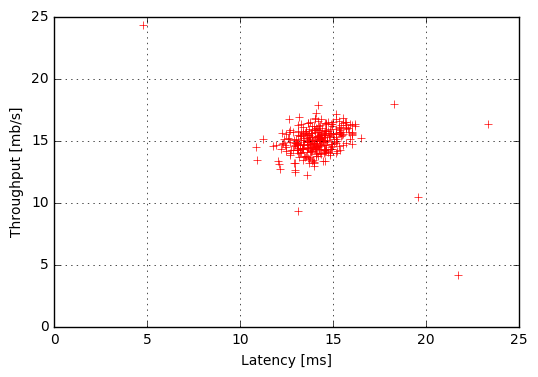

In [9]:
plotData(X)

### 2. Parameters of Gaussian

In [10]:
def getGaussianParams(X, useMultivariate=True):
    m = X.shape[0]
    mu = np.mean(X, axis=0) # axis=0 means to concatenate all the rows
    if useMultivariate:
        sigma2 = (X-mu).T.dot(X-mu)/m
    else:
        sigma2 = np.sum(np.square(X-mu), axis=0)/m
    return mu, sigma2

In [11]:
mu, sigma2 = getGaussianParams(X)

### 3. Visualize Gaussian Distribution

In [12]:
def gaussian(X, mu, sigma2):
    m = X.shape[0]
    n = X.shape[1]
    if np.ndim(sigma2)==1:
        sigma2 = np.diag(sigma2)
    norm = np.power(2*np.pi, -n/2)*np.power(np.linalg.det(sigma2),-1/2)
    sigma2_inv = np.linalg.inv(sigma2)
    p = np.zeros((m,1))
    for irow in range(m):
        xrow = X[irow]
        p[irow] = np.exp(-0.5*((xrow-mu).T).dot(sigma2_inv).dot(xrow-mu))
    return p*norm

In [13]:
def plotContours(mu, sigma2, newFig=False, useMultivariate=True):
    delta = 0.5
    xx = np.arange(0,30,delta)
    yy = np.arange(0,30,delta)
    meshx, meshy = np.meshgrid(xx,yy)
    point_list = [p.ravel() for p in (meshx, meshy)]
    points = np.vstack(point_list).T
    z = gaussian(points, mu, sigma2)
    z = z.reshape((xx.shape[0],xx.shape[0]))
    cont_levels = [10**exp for exp in range(-20,0,3)]
    plt.contour(meshx, meshy, z, levels=cont_levels)
    plt.title('Gaussian Contours')

C:\Users\User\Anaconda3\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Users\User\Anaconda3\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


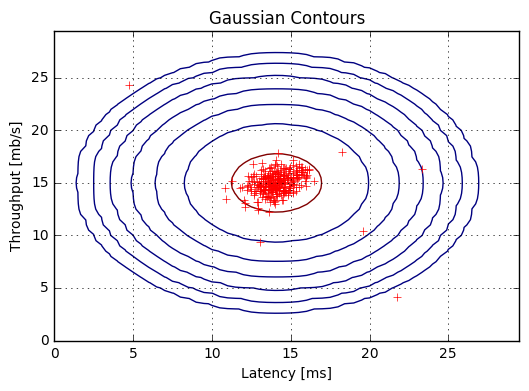

In [14]:
plotData(X)
useMultivariate = False
plotContours(*getGaussianParams(X, useMultivariate), newFig=False, useMultivariate = useMultivariate)

### 4. Threshold Value

In [15]:
def computeF1(prediction, yval):
    # precision
    P = np.sum(prediction[i] for i in range(prediction.shape[0]) if yval[i]==1)/np.sum(prediction)
    
    # recall
    R = np.sum(prediction[i] for i in range(prediction.shape[0]) if yval[i]==1)/np.sum(yval)
    
    # F1=2*P*R/(P+R)
    F1 = 2*P*R/(P+R)
    return F1

In [16]:
def thresholdValue(pval, yval):
    threshold_list = np.linspace(np.min(pval), np.max(pval), 1000)
    best_threshold = 0
    best_F1 = 0
    for i in threshold_list:
        prediction = (pval<i)
        F1 = computeF1(prediction, yval)
        if F1>best_F1:
            best_F1 = F1
            best_threshold = i
    return best_threshold

In [17]:
pval = gaussian(Xval, mu, sigma2)
threshold = thresholdValue(pval, yval)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: invalid value encountered in greater


In [18]:
threshold

9.0748445729657061e-05

In [19]:
def plotAnomaly(anomaly, newFig=False):
    if newFig:
        plt.figure()
    plt.scatter(anomaly[:,0], anomaly[:,1], s=60, facecolors='none', edgecolors='r')

C:\Users\User\Anaconda3\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Users\User\Anaconda3\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


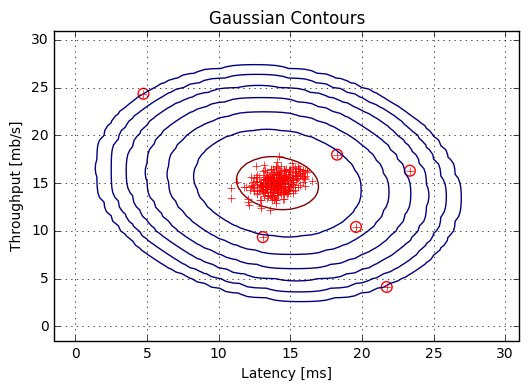

In [20]:
p = gaussian(X, mu, sigma2)
anomaly_idx = (p<threshold)
anomaly = np.array([X[i] for i in range(X.shape[0]) if anomaly_idx[i]])
plotData(X)
plotContours(mu, sigma2, newFig=False, useMultivariate=True)
plotAnomaly(anomaly, newFig=False)